2.2.0
Size of:
- Training-set:		184800
- Test-set:		30800


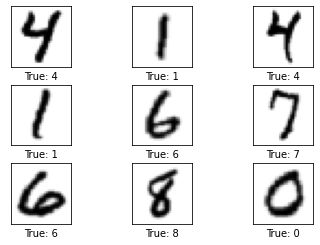

Train on 184800 samples, validate on 30800 samples
Epoch 1/3
184800/184800 [==============================] - 23s 124us/step - loss: 0.8223 - acc: 0.7427 - val_loss: 0.4021 - val_acc: 0.8612
Epoch 2/3
184800/184800 [==============================] - 23s 122us/step - loss: 0.5198 - acc: 0.8286 - val_loss: 0.3592 - val_acc: 0.8744
Epoch 3/3
184800/184800 [==============================] - 23s 122us/step - loss: 0.4784 - acc: 0.8415 - val_loss: 0.3662 - val_acc: 0.8778
Test loss:  0.36615512469565714
Test accuracy:  0.8777597546577454


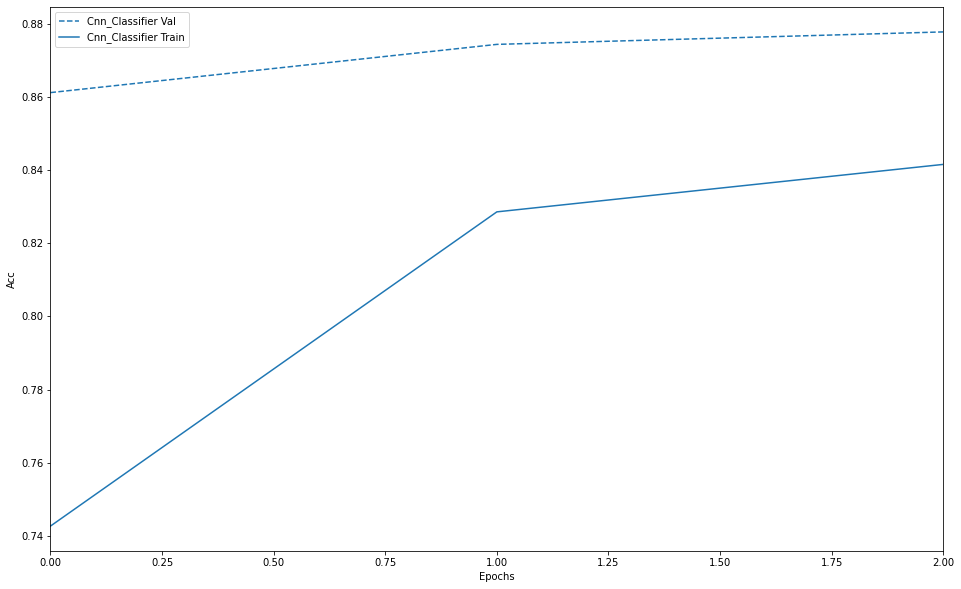

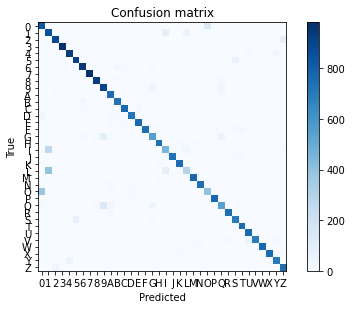

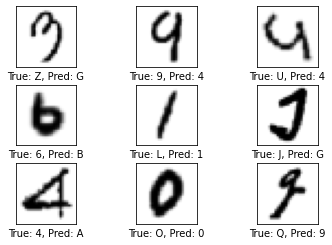

In [0]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy 
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adadelta

from sklearn.metrics import confusion_matrix

print(tf.__version__)


def plot_history(histories, key='acc'):
    """
     Args:
         histories: list of tuples. Each tuple is composed by a string (name of the model) and the history (output of
                    model.fit())
                    e.g. histories = [('CNN_classifier', history)]
         key: string, key for the metric to visulize. e.g. 'acc' for accuracy
     Return:
         it plots the training and the validation accuracy during the training
     """
    plt.figure(figsize=(16, 10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                       '--', label=name.title() + ' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])
    plt.show()


def print_confusion_matrix(model, images, labels, num_classes, class_names):
    """
    Args:
        model: Keras model, already trained
        images: numpy tensor containing the test images
                [image_num, height, width, channels]
        labels: list of int, dataset labels (sparse representation)
        num_classes: int, number of classes
        class_names: list of string, name assiciated to each class
    Return:
        It prints the confusion matrix
    """
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the true classifications for the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels,
    y_pred=np.argmax(predictions,axis=1))
    # Print the confusion matrix as text.
    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.title('Confusion matrix')
    plt.show()


def plot_images(images, labels, class_names, predictions=None):
    """
    Args:
        images: numpy tensor containing 9 test images
                [image_num, height, width, channels]
        labels: list of int, dataset labels of 9 examples (sparse representation)
        class_names: list of string, name assicuated to each class
        predictions: output of the model on 9 images from the dataset (contains the class PDF for each image)
    Return:
        It plots the provided 9 images with the label from the dataset,
        eventually with the model predictions
    """
    assert len(images) == len(labels) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].squeeze(), cmap='binary')
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {}".format(class_names[labels[i]])
        else:
            predictions_in = np.argmax(predictions, axis=1)
            xlabel = "True: {}, Pred: {}".format(class_names[labels[i]], class_names[predictions_in[i]])
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


def plot_example_errors(model, images, labels, class_names):
    """
    Args:
        model: Keras model, already trained
        images: numpy tensor containing the test images
               [image_num, height, width, channels]
        labels: list of int, dataset labels (sparse representation)
        class_names: list of string, name assicuated to each class
    Return:
        It prints the confusion matrix
    """
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)

    predictions_in = np.argmax(predictions, axis=1)
    correct = (predictions_in == labels)

    # Negate the boolean array.
    incorrect = (correct == False)
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images[incorrect]
    # Get the predicted classes for those images.
    cls_pred = predictions[incorrect]
    # Get the true classes for those images.
    cls_true = labels[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                labels=cls_true[0:9],
                class_names = class_names,
                predictions=cls_pred[0:9])


def plot_image(i, predictions, labels, images, class_names):
    """
    Args:
        i: int, index of the selected image in the dataset
        predictions: output of the model on the whole dataset (contains the class PDF for each image)
        labels: list of int, dataset labels (sparse representation)
        images: numpy tensor containing the test images
               [image_num, height, width, channels]
        class_names: list of string, name assicuated to each class
    Return:
        it plots the selected image with the label and the predicted class
    """
    predictions_array, true_label, img = predictions[i], labels[i], images[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)


def plot_value_array(i, predictions, labels, num_classes):
    """
    Args:
        i: int, index of the selected image in the dataset
        predictions: output of the model on the whole dataset (contains the class PDF for each image)
        labels: list of int, dataset labels (sparse representation)
        num_classes: int, number of classes
    Return:
        it plots the class PDF
    """
    predictions_array, true_label = predictions[i], labels[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


def image_with_PDF(images, labels, predictions, num_classes, class_names):
    """
    Args:
        images: numpy tensor containing the test images
                [image_num, height, width, channels]
        labels: list of int, labels related to 'images' (sparse representation)
        predictions: output of the model on 'images' (contains the class PDF for each image)
        num_classes: int, number of classes
        class_names: list of string, name assicuated to each class
    Return:
        It plots 15 images with the label from the dataset,
        the model prediction and the predicted PDF
    """

    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, labels, np.squeeze(images), class_names)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, labels, num_classes)
    plt.show()


def load_dataset(folder):
    """
    Args:
        folder: string, path to the folder containing the downloaded datasets
    Return:
        train_images, test_images: numpy tensors containing
                the training and test images
                [image_num, height, width, channels]
        train_labels, test_labels: list of int, they containing the correct class indices for
                                    each of the images in train_images, test_images
    """
    # MNIST-digits
    img_shape = 28 # size of the MNIST images
    digits = np.load(os.path.join(folder,'emnist-numbers.npz'))

    #reshape data
    train_images = digits['train_images'].reshape((-1, img_shape, img_shape, 1), order="F")
    train_labels = digits['train_labels'].reshape((-1,))
    test_images = digits['test_images'].reshape((-1, img_shape, img_shape, 1), order="F")
    test_labels = digits['test_labels'].reshape((-1,))

    # MNIST-letters
    letters = np.load(os.path.join(folder, 'emnist-letters.npz'))

    train_images = np.concatenate((train_images, letters['train_images'].reshape((-1, img_shape, img_shape, 1), order="F")),
                                  axis=0)
    train_labels = np.concatenate((train_labels, letters['train_labels'].reshape((-1,)) + 10), axis=0)
    test_images = np.concatenate((test_images, letters['test_images'].reshape((-1, img_shape, img_shape, 1), order="F")),
                                 axis=0)
    test_labels = np.concatenate((test_labels, letters['test_labels'].reshape((-1,)) + 10), axis=0)

    # permute data
    ord = np.random.permutation(test_labels.shape[0])
    test_images = test_images[ord]
    test_labels = test_labels[ord]

    return train_images, train_labels, test_images, test_labels


def main():
    # read data (digits and letters)
    img_shape = 28 # size of the MNIST images
    folder = os.path.join(os.getcwd(), '/content/drive/My Drive/EMNIST')
    train_images, train_labels, test_images, test_labels = load_dataset(folder)

    print("Size of:")
    print("- Training-set:\t\t{}".format(train_images.shape[0]))
    print("- Test-set:\t\t{}".format(test_images.shape[0]))

    batch_size = 64
    num_classes = 36
    epochs = 3

    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                   'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                   'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                   'U', 'V', 'W', 'X', 'Y', 'Z']

    # Data preprocessing: image normalization
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # Plot images
    plot_images(train_images[:9], train_labels[:9], class_names)

    train_labels = keras.utils.to_categorical(train_labels, num_classes)
    test_labels = keras.utils.to_categorical(test_labels, num_classes)

    # Create Keras model and evaluate its performance
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_images[0].shape))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=categorical_crossentropy, optimizer=Adadelta(), metrics=['acc'])
    history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_images, test_labels))   
    score = model.evaluate(test_images, test_labels, verbose=0)

    print('Test loss: ',score[0])
    print('Test accuracy: ',score[1])

    '''
    use np.argmax(test_labels, axis=1) instead of test_labels
    loss='sparse_categorical_crossentropy'
    '''

    plot_history([('CNN_classifier', history)])
    print_confusion_matrix(model, test_images, np.argmax(test_labels, axis=1), num_classes, class_names)
    plot_example_errors(model, test_images, np.argmax(test_labels, axis=1), class_names)

    keras.backend.clear_session()

if __name__ == '__main__':
    main()